In [3]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve,auc,confusion_matrix
from ipyfilechooser import FileChooser
import os
from tensorflow import keras,config,argmax
from keras.callbacks import ModelCheckpoint
from PIL import Image
from tensorflow.keras.layers import Dense,Flatten,MaxPooling2D,Conv2D,Dropout
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [2]:

x_train=np.zeros((680,299,299))
y_train=np.zeros((680))
x_val=np.zeros((120,299,299))
y_val=np.zeros((120))
i=0
for filename in os.listdir("base_dir/train_dir/Normal"):
    image = Image.open(f"base_dir/train_dir/Normal/{filename}")
    image = image.convert('L')
    x_train[i]=np.array(image)
    y_train[i]=0
    i= i+1
for filename in os.listdir("base_dir/train_dir/Tuberculosis"):
    image = Image.open(f"base_dir/train_dir/Tuberculosis/{filename}")
    image = image.convert('L')
    x_train[i]=np.array(image)
    y_train[i] =1
    i=i+1
i=0
for filename in os.listdir("base_dir/val_dir/Normal"):
    image = Image.open(f"base_dir/val_dir/Normal/{filename}")
    image = image.convert('L')
    x_val[i]=np.array(image)
    y_val[i]=0
    i= i+1
for filename in os.listdir("base_dir/val_dir/Tuberculosis"):
    image = Image.open(f"base_dir/val_dir/Tuberculosis/{filename}")
    image = image.convert('L')
    x_val[i]=np.array(image)
    y_val[i] =1
    i=i+1


In [4]:
#Перемешивание тренировочных данных
train_idx = np.random.permutation(x_train.shape[0])
val_idx = np.random.permutation(x_val.shape[0])
x_train, y_train = x_train[train_idx], y_train[train_idx]
x_val, y_val = x_val[val_idx],y_val[val_idx]

In [5]:
x_train = x_train / 255
x_val = x_val / 255
x_train = np.expand_dims(x_train,axis=3)
x_val = np.expand_dims(x_val,axis=3)

In [6]:
CAT = 2
y_val_cat = keras.utils.to_categorical(y_val, CAT)
y_train_cat = keras.utils.to_categorical(y_train, CAT)

In [7]:
train_size = int(x_train.shape[0]*0.85)+1
print(train_size)
x_test= x_train[train_size:]
x_train=x_train[0:train_size]
y_test_cat= y_train_cat[train_size:]
y_train_cat=y_train_cat[0:train_size]

647


In [8]:
x_train.shape[0]+x_test.shape[0]

680

/home/cond3nz/.local/lib/python3.10/site-packages/matplotlib/text.py:1242: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


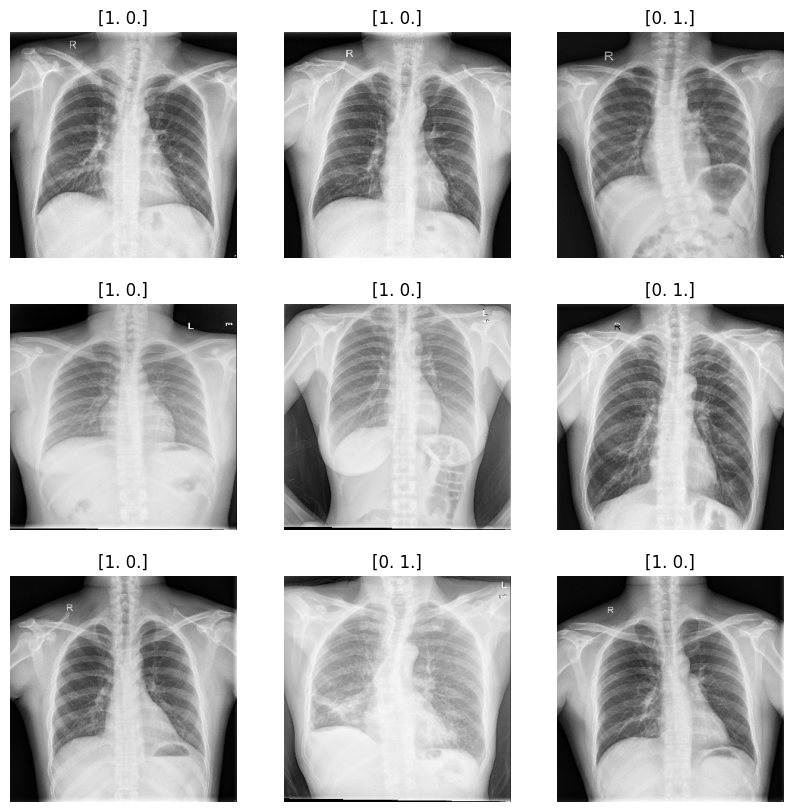

In [9]:
plt.figure(figsize=(10,10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(x_train[i], cmap='gray')
    plt.title(y_train_cat[i])
    plt.axis('off')

In [10]:
model = keras.Sequential([
    Conv2D(32, (3,3), padding='same', activation='relu', input_shape=(299, 299,1)),
    MaxPooling2D((2, 2), strides=2),
    Conv2D(64, (3,3), padding='same', activation='relu'),
    MaxPooling2D((2, 2), strides=2),
    Conv2D(128, (3,3), padding='same', activation='relu'),
    MaxPooling2D((2, 2), strides=2),
    Conv2D(256, (3,3), padding='same', activation='relu'),
    Conv2D(256, (3,3), padding='same', activation='relu'),
    MaxPooling2D((2, 2), strides=2),
    Flatten(),
    Dense(1024, activation='relu'),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(2,  activation='softmax')
])

2022-10-07 18:16:51.694697: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-07 18:16:51.694966: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-07 18:16:51.695061: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-10-07 18:16:51.695131: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2022-10-07 18:16:51.695198: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Co

In [11]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [12]:
batch_size=80
num_epochs=17

In [13]:
print(x_train.shape)
print(y_train_cat.shape)
print(x_val.shape)
print(y_val_cat.shape)

(647, 299, 299, 1)
(647, 2)
(120, 299, 299, 1)
(120, 2)


In [14]:
model_checkpoint_callback = ModelCheckpoint(
    filepath="checkpint_weights",
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [15]:
log = model.fit(x_train, y_train_cat, batch_size=batch_size, epochs=num_epochs,validation_data=(x_val, y_val_cat),callbacks=[model_checkpoint_callback])

Epoch 1/17
9/9 [==============================] - 99s 11s/step - loss: 0.8010 - accuracy: 0.5193 - val_loss: 0.7030 - val_accuracy: 0.5083
Epoch 2/17
9/9 [==============================] - 82s 9s/step - loss: 0.6969 - accuracy: 0.4900 - val_loss: 0.6930 - val_accuracy: 0.4917
Epoch 3/17
9/9 [==============================] - 82s 9s/step - loss: 0.6933 - accuracy: 0.5054 - val_loss: 0.6924 - val_accuracy: 0.5083
Epoch 4/17
9/9 [==============================] - 103s 12s/step - loss: 0.6854 - accuracy: 0.5641 - val_loss: 0.6631 - val_accuracy: 0.7167
Epoch 5/17
9/9 [==============================] - 109s 12s/step - loss: 0.6541 - accuracy: 0.6631 - val_loss: 0.5482 - val_accuracy: 0.7417
Epoch 6/17
9/9 [==============================] - 96s 10s/step - loss: 0.5695 - accuracy: 0.7450 - val_loss: 0.5913 - val_accuracy: 0.7333
Epoch 7/17
9/9 [==============================] - 93s 10s/step - loss: 0.5470 - accuracy: 0.7543 - val_loss: 0.5211 - val_accuracy: 0.7333
Epoch 8/17
9/9 [===========

In [16]:
model.evaluate(x_test,y_test_cat)

2/2 [==============================] - 1s 66ms/step - loss: 0.1722 - accuracy: 0.9091


[0.17216075956821442, 0.9090909361839294]

In [17]:
model.load_weights("checkpint_weights")

In [18]:
model.evaluate(x_test,y_test_cat)

2/2 [==============================] - 1s 66ms/step - loss: 0.1873 - accuracy: 0.9394


[0.18732085824012756, 0.939393937587738]

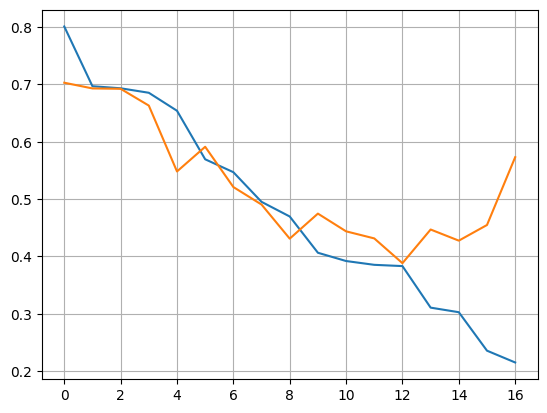

In [19]:
plt.plot(log.history['loss'])
plt.plot(log.history['val_loss'])

plt.grid(True)
plt.show()

In [20]:
model.save("CNN_TubRec")

INFO:tensorflow:Assets written to: CNN_TubRec/assets


INFO:tensorflow:Assets written to: CNN_TubRec/assets


In [21]:
loaded_model = keras.models.load_model('CNN_TubRec')

In [22]:
fdialog = FileChooser(
    os.getcwd(),
    filename="tub.png",
    title='<b>Выберите файл</b>',
    show_hidden=False,
    select_default=True,
    show_only_dirs=False
)

display(fdialog)

FileChooser(path='/home/cond3nz/src/DZPG', filename='tub.png', title='<b>Выберите файл</b>', show_hidden=False…

In [23]:
image= Image.open(fdialog.selected)
image = image.convert("L")
array = np.array(image)/255


1/1 [==============================] - 0s 173ms/step


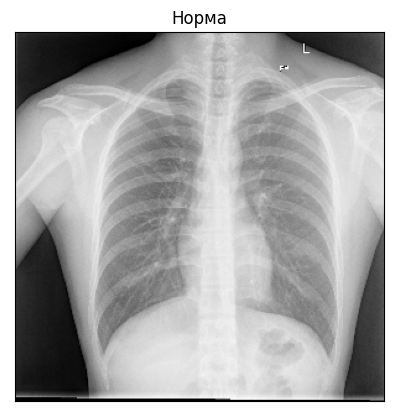

In [24]:
res = loaded_model.predict(np.expand_dims(array,axis=0))
plt.imshow(array,cmap="gray")
plt.xticks([])
plt.yticks([])
if np.argmax(res) == 0:
    plt.title("Норма")
else:
    plt.title("Патология")

In [25]:
y_pred = loaded_model.predict(x_test)

2/2 [==============================] - 1s 63ms/step


In [26]:
fprz, tprz, thresholdsz = roc_curve(y_test_cat[:,0],y_pred[:,0])
fpro, tpro, thresholdso = roc_curve(y_test_cat[:,1],y_pred[:,1])

In [27]:
roc_aucz = auc(fprz, tprz)
roc_auco = auc(fpro, tpro)

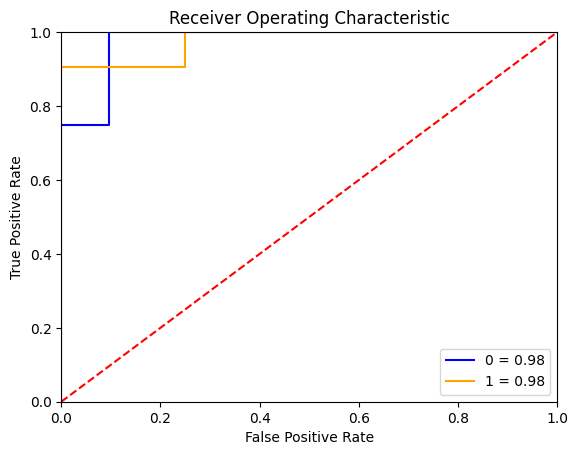

In [28]:
plt.title('Receiver Operating Characteristic')
plt.plot(fprz, tprz, 'blue', label = '0 = %0.2f' % roc_aucz)
plt.plot(fpro, tpro, 'orange', label = '1 = %0.2f' % roc_auco)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [29]:
cf_matrix=confusion_matrix(argmax(y_test_cat,1),argmax(y_pred,1))

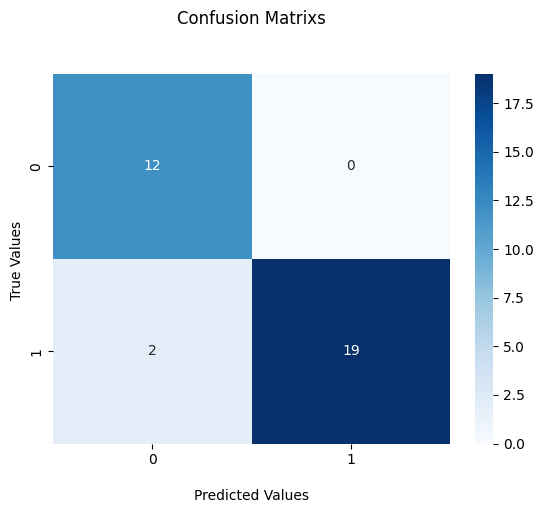

In [30]:
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

ax.set_title('Confusion Matrixs\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('True Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['0','1'])
ax.yaxis.set_ticklabels(['0','1'])

## Display the visualization of the Confusion Matrix.
plt.show()